# Can a machine learning program distringuish German speakers from Swedish speakers?

We present an attempt to determine whether spectrograms of Swedish and German conversations (both male and femals) can be distinguished by machine learning algorithms, or else, maybe ML can at least distinguish between male and female voices.

We know ML can distinguish bird calls by looking at spectrograms, but spectrograms of conversational streams of two fairly closely related languages will presumably be harder to distinguish. 

The dataset to be used in resolv consists of snippets of Swedish and German conversation, 10-11 seconds in length, taken from interviews, news broadcasts and other video clips (and recorded in mono with Audacity). If, by the time you read this, some other languages have been added, so be it. You can just delete those directories, if you wish to replicate only the Swedish/German differentiation.

In [1]:
## Converting .wav files to spectrograms
### ( using https://dolby.io/blog/beginners-guide-to-visualizing-audio-as-a-spectogram-in-python/)

NOTE: You may be asked for both your Kaggle name and your Kaggle key (or else, by the time anyone else reads this, some new protocol will be in place, in which case, appreciate the fact that I at least tried to help walk you through this).
    
If you go to your Kaggle account and look at the URL it will be the
portion between the '/' characters that follows 'kaggle.com'. As for the
key, you must generate and download an API key (see the API section on your account page -- i.e. the button that says 'Create New API Token'), then open the file with a text browser (e.g. Notepad++ or TextEdit, depending on your OS) and then copy the "key" value in the dictionary
you see defined there -- note the file also contains the username.

In [2]:
import os 
import shutil

# for data transformation
import numpy as np
# for visualizing the data
import matplotlib.pyplot as plt
# for opening the media file
import scipy.io.wavfile as wavfile

In [3]:
!pip install opendatasets

In [78]:
!cd ./swedishgerman10secondconversationalwav/

In [81]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/hjhrgov/swedishgerman10secondconversationalwav")

Skipping, found downloaded files in "./swedishgerman10secondconversationalwav" (use force=True to force download)


In [82]:
thisDirectiory = "/kaggle/working/swedishgerman10secondconversationalwav/ML_speech_recognition"
langList = ['german', 'swedish']
os.chdir(thisDirectiory)

In [83]:
import glob
fList = glob.glob('./*/*.wav')

# all files are between 10 and 11 seconds long, so we'll trim them all to 10 seconds
print(fList)
nSseconds = 10
wavFName = fList[62]

print(fList)

Fs, aud = wavfile.read(wavFName)

# our files are in mono, so we can delete the follwing
  # select left channel only
  #aud = aud[:,0]

# trim the files to the desired number of seconds
first = aud[:int(Fs*nSseconds)]
first.shape

['./swedish/F_SelmaStories.wav', './swedish/M_SecretService.wav', './swedish/M_20231701PerHilmersson.wav', './swedish/F_AgnethaFaltskogInterviewer.wav', './swedish/F_20231501SusanneBjerenot.wav', './swedish/M_JonBranstromm.wav', './swedish/M_SpelKult2.wav', './swedish/F_KvinnorTrakasseras.wav', './swedish/F_20231801HannaHederstedt.wav', './swedish/F_20230113FemaleInterrogator.wav', './swedish/F_AlexanderSkarsgardReporter.wav', './swedish/F_20231701G.wav', './swedish/M_20231801JonasBjorkstrom.wav', './swedish/F_20231801SolveigHaggkvist.wav', './swedish/F_PerSindingLarsen.wav', './swedish/F_ArnTempelriddarenWoman.wav', './swedish/M_Sebastian_Samuelsson.wav', './swedish/F_20221216HibaDaniel.wav', './swedish/M_20231801NiklasSobieski.wav', './swedish/M_20231701E.wav', './swedish/M_ErikPenserBankInterviewer.wav', './swedish/M_20221221FredrikRalstand.wav', './swedish/M_ArnTempelriddarenNarrator.wav', './swedish/F_MalinLundgren.wav', './swedish/M_PatrikAndersson.wav', './swedish/F_20231701D.wa

(441000,)

In [84]:
len(fList)

204

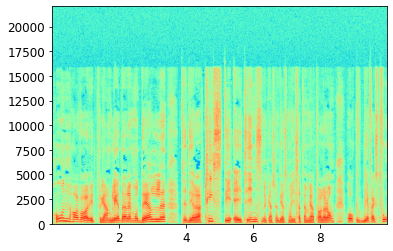

In [85]:
nfft = 1024
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs,  NFFT=nfft, mode='psd',cmap='rainbow')
#plt.show()

pngName = wavFName[:-3] + 'png'
pngNameExtra = ("./" + pngName[2:]) 

plt.savefig(pngNameExtra) 

We shall delete any ticks or other markings, in case we need to use data augmentation that crops and magnifies portions of our image files.


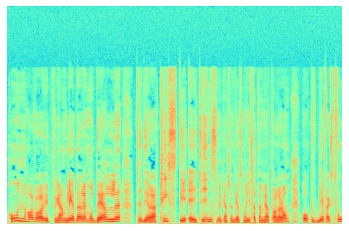

In [86]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs,  NFFT=nfft, mode='psd',cmap='rainbow')
#plt.show()

pngName = wavFName[:-3] + 'png'
# we remove axis, tick marks, frame -- everything but spectrogram itself
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("./" + pngName[2:]) 

After playing with the parameters, it seems that the NFFT arg should be larger than the default of 256, and once we set it to 1024 or higher, we see the nice wood-grain feature at the bottom of the axis that many associate with sound spectrograms. Moreover, that bottom seems to be the most interesting portion. So, let's try to limit the spectrum to 6k or 7k, initially.

./swedish/F_MalouVonSivers.png


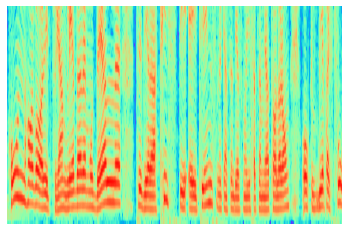

In [87]:
import matplotlib.mlab as mlab

# modified specgram()
# see https://stackoverflow.com/questions/19468923/cutting-of-unused-frequencies-in-specgram-matplotlib
max_freq = 2500 # 500 * 1000 # 4000 # 2500 #1500 # 8000



def my_specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
             window=mlab.window_hanning, noverlap=128,
             cmap=None, xextent=None, pad_to=None, sides='default',
             scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs):
    """
    call signature::

      specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
               window=mlab.window_hanning, noverlap=128,
               cmap=None, xextent=None, pad_to=None, sides='default',
               scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs)

    Compute a spectrogram of data in *x*.  Data are split into
    *NFFT* length segments and the PSD of each section is
    computed.  The windowing function *window* is applied to each
    segment, and the amount of overlap of each segment is
    specified with *noverlap*.

    %(PSD)s

      *Fc*: integer
        The center frequency of *x* (defaults to 0), which offsets
        the y extents of the plot to reflect the frequency range used
        when a signal is acquired and then filtered and downsampled to
        baseband.

      *cmap*:
        A :class:`matplotlib.cm.Colormap` instance; if *None* use
        default determined by rc

      *xextent*:
        The image extent along the x-axis. xextent = (xmin,xmax)
        The default is (0,max(bins)), where bins is the return
        value from :func:`mlab.specgram`

      *minfreq, maxfreq*
        Limits y-axis. Both required

      *kwargs*:

        Additional kwargs are passed on to imshow which makes the
        specgram image

      Return value is (*Pxx*, *freqs*, *bins*, *im*):

      - *bins* are the time points the spectrogram is calculated over
      - *freqs* is an array of frequencies
      - *Pxx* is a len(times) x len(freqs) array of power
      - *im* is a :class:`matplotlib.image.AxesImage` instance

    Note: If *x* is real (i.e. non-complex), only the positive
    spectrum is shown.  If *x* is complex, both positive and
    negative parts of the spectrum are shown.  This can be
    overridden using the *sides* keyword argument.

    **Example:**

    .. plot:: mpl_examples/pylab_examples/specgram_demo.py

    """

    #####################################
    # modified  axes.specgram() to limit
    # the frequencies plotted
    #####################################

    # this will fail if there isn't a current axis in the global scope
    ax = plt.gca()
    Pxx, freqs, bins = mlab.specgram(x, NFFT, Fs, detrend,
         window, noverlap, pad_to, sides, scale_by_freq)

    # modified here
    #####################################
    if minfreq is not None and maxfreq is not None:
        Pxx = Pxx[(freqs >= minfreq) & (freqs <= maxfreq)]
        freqs = freqs[(freqs >= minfreq) & (freqs <= maxfreq)]
    #####################################
    
    if False:
        # let's also make the higher frequencies less dense
        # replacing them with an average over several nearby frequencies
        #####################################
        newfreqs = []
        #print(freqs.type)

        #import pdb; pdb.set_trace()
        i_prevfreq = -1
        for iifreq, ifreq in enumerate(list(freqs)):
            if ifreq <= 2000:
                newfreqs.append(ifreq)
                i_prevfreq = iifreq
            elif ifreq <= 4000:
                spacing = 2
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq
            elif ifreq < 8000:
                spacing = 4
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq  
            elif ifreq < 16000:
                spacing = 8
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq   
            else:
                spacing = 16
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq 

        freqs = np.array(newfreqs)
        #####################################
    
    
    
    

    Z = 10. * np.log10(Pxx)
    Z = np.flipud(Z)

    if xextent is None: xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    freqs += Fc
    extent = xmin, xmax, freqs[0], freqs[-1]
    
    
    # I modify the stackoverflow answer to remove ticks and axis
    ax.axis('auto')
    #plt.cla()
    #plt.clf()
    #plt.close()


    im = ax.imshow(Z, cmap, extent=extent, **kwargs)
    
    
    return Pxx, freqs, bins, im

# plot
#ax1 = plt.plot()

# the minfreq and maxfreq args will limit the frequencies 
Pxx, freqs, time, imageAxis = my_specgram(first,nfft, Fs, noverlap=128, 
                                cmap="rainbow", minfreq = 0, maxfreq = max_freq)
# strip off everything but spectrogram itself
plt.axis('auto')
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig(pngNameExtra)
#plt.show()
print(pngNameExtra)


In [88]:
print(pngName)

./swedish/F_MalouVonSivers.png


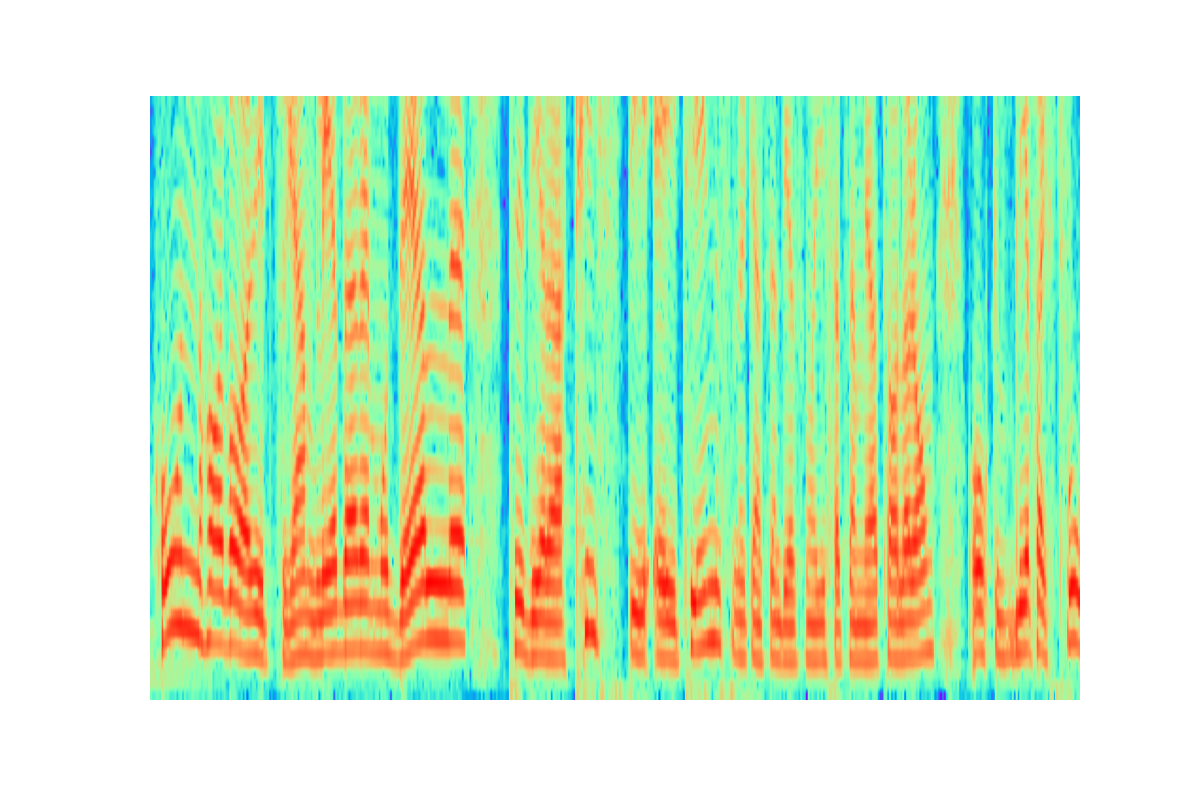

In [89]:
#os.chdir("./")
import IPython
IPython.display.Image(pngNameExtra)

That looks good -- let's do the rest of the batch, and again, we will be sure to strip off any tick marks or labels

In [90]:
fList = glob.glob('./*/*.png') 
len(fList)

205

In [91]:
# delete any other image files that might be present
# from some previous run with some other maximum frequency

bDeletePrevImageFiles = True
if bDeletePrevImageFiles:
    fList = glob.glob('./*/*.png')
    if len(fList) > 0:
        print("Removing " + str(len(fList)) + " existing image files.")
    for iFile in fList:
        os.remove(iFile)

for i_lang in langList:
    i_iter = 0
    fList = glob.glob('./' + i_lang + '/*.wav')
    N_langbatch = len(fList)
    if len(glob.glob('./' + i_lang + '/*.wav')) == 0:
        print("WARNING: zero files found corresponding to ./ML_speech_recognition/" + i_lang + "/*.wav")
        continue
    
    for wavfname in fList:

        try:
            Fs, aud = wavfile.read(wavfname)
        except:
            print("Could not read " + wavfname)
        if i_iter % 10 == 0:
            print("Working on the " + i_lang + " files and processing file " + str(i_iter) + " out of " + str(N_langbatch))
        i_iter += 1
        # trim the files to the desired number of seconds
        first = aud[:int(Fs*nSseconds)]
        first.shape
        #powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
        #plt.show()
        pngName = wavfname[:-3] + 'png'
        powerSpectrum, frequenciesFound, time, imageAxis = my_specgram(first, nfft, Fs, 128, 
                                cmap="rainbow", minfreq = 0, maxfreq = max_freq)
        
        
        #plt.axis('off')

        #plt.show(imageAxis)
        #plt.savefig(pngname) #save as png
        #plt.clear()
        

        
        plt.axis('auto')
        #plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        
        gc = plt.gcf()
        gc.savefig(pngName)
        #plt.show(); 
        #print(wavfname)
        plt.close()
        #img = matplotlib.image.imread(pngname)
        #plt.imshow(img)
        #plt.cla()
        #plt.clf()
        plt.close()
        
        #if i_iter > 2:
        #    break
    
        
    print("completed " + i_lang + " files")

Removing 205 existing image files.
Working on the german files and processing file 0 out of 101
Working on the german files and processing file 10 out of 101
Working on the german files and processing file 20 out of 101
Working on the german files and processing file 30 out of 101
Working on the german files and processing file 40 out of 101
Working on the german files and processing file 50 out of 101
Working on the german files and processing file 60 out of 101
Working on the german files and processing file 70 out of 101
Working on the german files and processing file 80 out of 101
Working on the german files and processing file 90 out of 101
Working on the german files and processing file 100 out of 101
completed german files
Working on the swedish files and processing file 0 out of 103
Working on the swedish files and processing file 10 out of 103
Working on the swedish files and processing file 20 out of 103
Working on the swedish files and processing file 30 out of 103
Working o

153
./german/M_20220113AndreasKynnacht.png


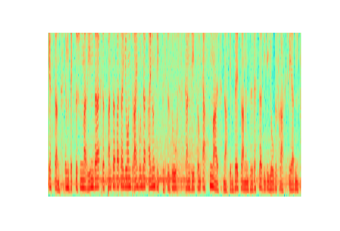

In [41]:
from PIL import Image

fList = glob.glob('./*/*.png') + glob.glob('./*/*/*.png')

whichFile = np.random.randint(0, len(fList))
import matplotlib.image as mpimg

img = mpimg.imread(fList[whichFile])
#plt.axis('auto')
plt.axis('off')
#plt.xticks([])
#plt.yticks([])
#plt.axis('off')

#plt.show()
#print(pngName)
plt.imshow(img)

print(whichFile)
print(fList[whichFile])

In [92]:
# now that we have some data files, let us move on to fastai
# what follows has been adapted from Jeremy Howard's "Is it a bird?"
# notebook
!pip install -Uqq fastai 

In [94]:
# we will need to modify the file names to include the language spoken 
# since it is easiest to dump all the image files into one directory
flist = glob.glob('./*/*.png')
for ifile in flist:
    ifilechunks = ifile.split('/')
    lang = ifilechunks[-2]
    newfname = '/'.join(ifilechunks[:-1]) + '/' + lang + '_' + ifilechunks[-1]
    os.rename(ifile, newfname)


In [96]:
fList = glob.glob('./*/*.png')
nFilesBeforeMove = len(fList)
print(nFilesBeforeMove)

204


In [97]:
!ls -lt .

import shutil
newDir = '.' + '/images'

if not(os.path.exists(newDir)):
    os.makedirs(newDir)

fList = glob.glob('./*/*.png')  # note previous fnames is no longer valid
for ifile in fList:
    newfile = newDir + '/' + ifile.split('/')[-1]
    shutil.move(ifile, newfile)
    


total 960
drwxr-xr-x 2 root root  20480 Jan 23 01:59 german
drwxr-xr-x 2 root root  16384 Jan 23 01:59 swedish
drwxr-xr-x 2 root root  16384 Jan 23 01:57 images
drwxr-xr-x 3 root root   4096 Jan 23 01:57 swedishgerman10secondconversationalwav
drwxr-xr-x 3 root root   4096 Jan 23 01:41 ML_speech_recognition
-rw-r--r-- 1 root root 897127 Jan 23 01:40 Converting_wav_files_to_jpg_spectrograms.ipynb
-rw-r--r-- 1 root root  14236 Jan 23 01:40 credits.txt


In [98]:
!ls -lt ./images/*


-rw-r--r-- 1 root root 608829 Jan 23 01:58 ./images/swedish_F_20231801AnnNyhlen.png
-rw-r--r-- 1 root root 529942 Jan 23 01:58 ./images/swedish_F_20231801MomSjorup.png
-rw-r--r-- 1 root root 474053 Jan 23 01:58 ./images/swedish_M_20221219JoakimEriksson.png
-rw-r--r-- 1 root root 547804 Jan 23 01:58 ./images/swedish_M_ErikPenserBank.png
-rw-r--r-- 1 root root 542060 Jan 23 01:58 ./images/swedish_M_20231701Nils.png
-rw-r--r-- 1 root root 575168 Jan 23 01:58 ./images/swedish_M_LinusHaggInterviewer.png
-rw-r--r-- 1 root root 492060 Jan 23 01:58 ./images/swedish_M_MartinEdlund.png
-rw-r--r-- 1 root root 597008 Jan 23 01:58 ./images/swedish_F_MinestoInterview.png
-rw-r--r-- 1 root root 487910 Jan 23 01:58 ./images/swedish_M_20230113FredrikLagelius.png
-rw-r--r-- 1 root root 545038 Jan 23 01:58 ./images/swedish_M_LinusHagg.png
-rw-r--r-- 1 root root 584476 Jan 23 01:58 ./images/swedish_F_20231801GunillaPettersson.png
-rw-r--r-- 1 root root 556573 Jan 23 01:58 ./images/swedish_M_AktieTorget.pn

In [99]:
fList = glob.glob('./*/*.png')
nFilesAfterMove = len(fList)
print(nFilesAfterMove)

204


In [100]:
if nFilesAfterMove != nFilesBeforeMove:
    print("Apparently some files got lost during the extraction\nfrom the separate language directories to the single 'image' directory. You need to find out what went wrong, and rerun...")

In [102]:
!pip install -Uqq fastbook

In [103]:
import fastbook 
fastbook.__version__

'0.0.29'

In [104]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [105]:
# some deprecated code that might prove useful to someone so I will leave it
#dblock = DataBlock()
#dsets = dblock.datasets(fnames)

In [106]:

bIgnoreMFSubclasses = True # if false, then male and female speakers 
                           #. of any language will be a separate class
def label_func(fname):
    #return "cat" if fname.name[0].isupper() else "dog"
    #print(fname.name)
    #return
    chunks = fname.name.split('/')
    subchunks = chunks[-1].split('_')
    if bIgnoreMFSubclasses:
        return subchunks[0]
    else:
        return '_'.join(subchunks[:2])

In [107]:
# an easier task is distinguishing male voices from female voices
# if you wish to try that, change the name of this function from 
# label_funcMF to label_func, thereby overriding the above definition.
# In that case, I was able to get the error rate down to 50% with just
# two hundred wav files
def label_funcMF(fname):
    #return "cat" if fname.name[0].isupper() else "dog"
    #print(fname.name)
    #return
    chunks = fname.name.split('/')
    subchunks = chunks[-1].split('_')
    if bIgnoreMFSubclasses:
        return subchunks[1] #'_'.join(subchunks[0:2])

In [108]:
# again, I will leave this here just in case it proves useful
#dblock = DataBlock(get_items = get_image_files, get_y = label_func)

In [109]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

In [110]:
path = './'
dsets = dblock.datasets(path + "images")

In [249]:
# let's peek in to what we have in our dataset
len(dsets.train)

164

In [112]:
dsets.vocab

['german', 'swedish']

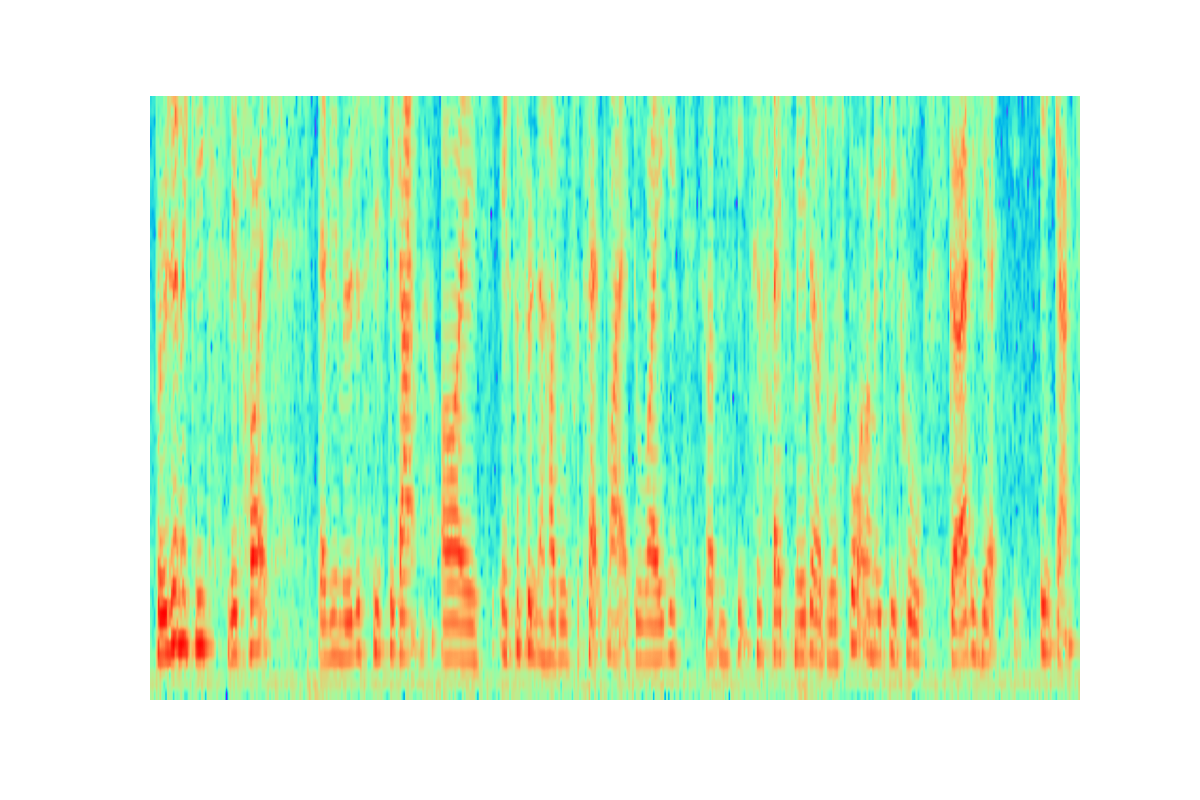

In [250]:
# here's a snapshot of one validation image
dsets.valid[39][0]

In [ ]:
#dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                   get_items = get_image_files,
#                   get_y     = label_func,
#                   splitter  = RandomSplitter())

In [239]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224)) 

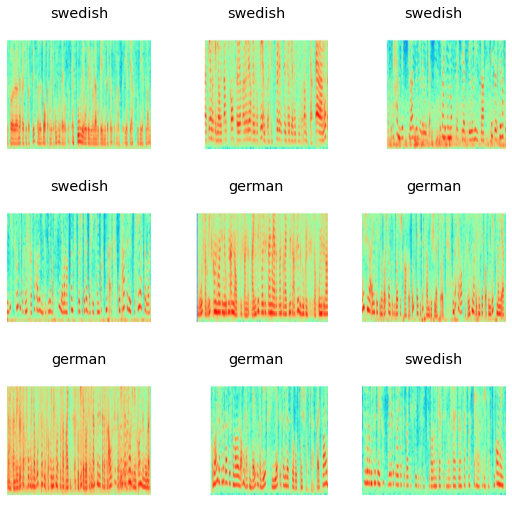

In [240]:
dls = dblock.dataloaders(path + "images")
dls.show_batch()

In [248]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(14)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.296040,1.846514,0.575000,00:20


epoch,train_loss,valid_loss,error_rate,time
0,1.096813,1.521509,0.575000,00:28
1,1.040897,1.005546,0.550000,00:27
2,1.017366,0.709917,0.400000,00:28
3,0.966068,0.606194,0.300000,00:28
4,0.855690,0.602935,0.325000,00:28
5,0.790047,0.598688,0.250000,00:27
6,0.730835,0.623769,0.250000,00:28
7,0.701145,0.626947,0.225000,00:27
8,0.644046,0.587631,0.175000,00:28
9,0.609050,0.601895,0.150000,00:28


By running this a few times, it is evident that the overall final error rate fluctuates wildly.

WHich is not so suprising, given how small our dataset. Evidently we need more images.

Still this is an auspicious start.

In [ ]:
# randomly pick up files and see how good it does
# (note most of these images were used to train, so this is not a fair test)
iwhich = 20


print(fList[iwhich])
is_swede,_,probs = learn.predict(PILImage.create(fList[iwhich]))
print(f"This is a: {is_swede}.")
print(f"Probability: {probs[0]:.4f}")
print(probs)

In [ ]:
# here's a similar approach, working on file names
fname = '/kaggle/working/swedishgerman10secondconversationalwav/images/swedish_M_20231801GunnarStrommer.png'

fname = fname.replace('swedishgerman10secondconversationalwav', 'swedishgerman10secondconversationalwav/ML_speech_recognition')
print(fname)
is_swede,_,probs = learn.predict(PILImage.create(fname))
print(f"This is a: {is_swede}.")
ind = 0
if is_swede == 'swedish':
    ind = 1
print(f"Probability: {probs[ind]:.4f}")
print(probs)


<style>
{float:left}


| ValidationSample | Score |
|----------|:-------------:|
| german_F_20221209MarieClaireKoch | Yes |
| swedish_M_SpelKult1 | Yes |
| german_F_HilkeBrockmann | Yes |
| german_F_20221213ClaraBunger | Yes |
| swedish_M_20221221FredrikRalstand | Yes |
| swedish_F_20230113FemaleInterrogator | Yes | 
| swedish_F_20230113FemaleInterrogator | Yes |
| swedish_M_20231801FredrikMalmgren | Yes |
 | german_M_20221010StefanMarzischiewski | Yes |
| swedish_F_20231501B |  WRONG !
wedish_M_DenisLyxenRefused | Yes |
| german_F_20230118SandraMaischberger | Yes |
| swedish_F_20231801AnnieLid | Yes |
| swedish_M_AlexanderSkarsgard | Yes |
| swedish_M_AktieTorget |   WRONG !
| german_F_20210725SusznneGellhardt | Yes |
| swedish_M_SecretService | Yes |
| german_F_KlausKinskiFEMALEInterviewer | Yes |
| german_F_20220605GesineLotzsch | Yes |
| german_M_20220510TheoKoll | Yes |
| swedish_F_20231701D | Yes |
| german_M_202210213GerdMuller | Yes |
| german_M_20221001JustusKliss | Yes |
| german_F_20230118AnjaKohl | Yes |
| german_F_20221001FrederikeHofmann | Yes |
| german_M_20221013MichaelKellner | Yes |
| german_M_20221110FrankWalterSteinmeier | Yes |
| german_M_20221110RobertHabeck | Yes |
| german_M_20230117ChristophArnowski | Yes |
| swedish_M_20221219JoakimEriksson | Yes |
| german_F_20221010PatriciaWiedermeyer | Yes |
| swedish_M_SpelKult2 | Yes |
| swedish_F_20231801MomSjorup | Yes |
| german_F_20221001SbrinaWendling | Yes |
| swedish_M_GustavSkarsgard | Yes |
| swedish_M_20221220PeterAxelsson | Yes |
| german_M_20221001CemOzdemir | Yes |
| swedish_F_SpelKult2 | Yes | 
| swedish_M_20231801GunnarStrommer | Yes | 

</style>


On one run (not the one above, to be precise), I went through the validation samples by hand, to see if there was something obvious about the samples that the program could not identify properly:


| ValidationSample | Score |
|----------|:-------------:|
| german_F_20221209MarieClaireKoch | Yes |
| swedish_M_SpelKult1 | Yes |
| german_F_HilkeBrockmann | Yes |
| german_F_20221213ClaraBunger | Yes |
| swedish_M_20221221FredrikRalstand | Yes |
| swedish_F_20230113FemaleInterrogator | Yes | 
| swedish_F_20230113FemaleInterrogator | Yes |
| swedish_M_20231801FredrikMalmgren | Yes |
| german_M_20221010StefanMarzischiewski | Yes |
| swedish_F_20231501B |  WRONG !
! swedish_M_DenisLyxenRefused | Yes |
| german_F_20230118SandraMaischberger | Yes |
| swedish_F_20231801AnnieLid | Yes |
| swedish_M_AlexanderSkarsgard | Yes |
| swedish_M_AktieTorget |   WRONG !
| german_F_20210725SusznneGellhardt | Yes |
| swedish_M_SecretService | Yes |
| german_F_KlausKinskiFEMALEInterviewer | Yes |
| german_F_20220605GesineLotzsch | Yes |
| german_M_20220510TheoKoll | Yes |
| swedish_F_20231701D | Yes |
| german_M_202210213GerdMuller | Yes |
| german_M_20221001JustusKliss | Yes |
| german_F_20230118AnjaKohl | Yes |
| german_F_20221001FrederikeHofmann | Yes |
| german_M_20221013MichaelKellner | Yes |
| german_M_20221110FrankWalterSteinmeier | Yes |
| german_M_20221110RobertHabeck | Yes |
| german_M_20230117ChristophArnowski | Yes |
| swedish_M_20221219JoakimEriksson | Yes |
| german_F_20221010PatriciaWiedermeyer | Yes |
| swedish_M_SpelKult2 | Yes |
| swedish_F_20231801MomSjorup | Yes |
| german_F_20221001SbrinaWendling | Yes |
| swedish_M_GustavSkarsgard | Yes |
| swedish_M_20221220PeterAxelsson | Yes |
| german_M_20221001CemOzdemir | Yes |
| swedish_F_SpelKult2 | Yes | 
| swedish_M_20231801GunnarStrommer | Yes | 


The two samples that failed are not particularly noisy or
noteworthy in any obvious way.
Both sounded Swedish to my relatively untrained ear, but their spectrograms apparently seemed
more indicative of German to the program. It is possible the voices have accents that are undetectable to
me, though that. may be true to any number of the other samples as well. Even so, this isnot bad if one’s entire exposure to German and Swedish come from spectrograms of 200 10-second wav files.



In [ ]:
!ls -lt